In [87]:
#from save_activations import load_activation_probing_dataset, load_activation_probing_dataset_args
#from feature_datasets import common
#from probes.evaluation import *

In [88]:
import torch
torch.manual_seed(42)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler

In [113]:
df = pd.read_csv("./hyper_hypo_activations1/dataset.csv")
df.sample(15)

,prompt,label
10243,Antheraea is a kind of arthropod genus,True
10825,Schistosomatidae is a kind of worm family,True
3756,niche is a kind of place,True
26101,eastern hemisphere is a kind of note,False
16240,Clethrionomys is a kind of mammal genus,True
22562,chemical notation is a kind of notation,True
4335,col is a kind of pass,True
29753,bailiff is a kind of middleweight,False
18468,reservist is a kind of soldier,True
2430,hatmaker is a kind of merchant,True


In [90]:
train_test_mask = (torch.rand(df.shape[0]) < 0.8).numpy()
print(f"Training samples: {train_test_mask.sum()} out of {train_test_mask.size}")
ratio = df.label[train_test_mask].sum() / (~df.label[train_test_mask]).sum() 
print(f"Within training dataset, True/False label ratio is {ratio:.5f}")

Training samples: 39956 out of 50000
Within training dataset, True/False label ratio is 1.00050


In [91]:
NUM_LAYERS = 40

def get_path_to_activations(layer_idx: int) -> str:
    return f"./hyper_hypo_activations1/{layer_idx:02}.pt"

In [92]:
# # Activations are too heavy (8G on disk), so loading all layers at once is not an option
# activations = []
# for layer_idx in range(NUM_LAYERS):
#     t = torch.load(get_path_to_activations(layer_idx)).dequantize()
#     activations.append(t)

In [93]:
def get_scores(labels: np.ndarray, pred: np.ndarray) -> dict[str, float]:
    return {
        'accuracy': accuracy_score(labels, pred),
        'precision': precision_score(labels, pred),
        'recall': recall_score(labels, pred),
        'f1': f1_score(labels, pred)
    }

def run_probe(
    activations: np.ndarray, labels: np.ndarray, train_test_mask: np.ndarray, regularization_strength: float = 2
) -> dict:
    train_activations = activations[train_test_mask]
    train_labels = labels[train_test_mask]
    test_activations = activations[~train_test_mask]
    test_labels = labels[~train_test_mask]

    scaler = MinMaxScaler()
    train_activations = scaler.fit_transform(train_activations)
    test_activations = scaler.transform(test_activations)
    
    probe = LogisticRegression(C=1/regularization_strength)
    probe.fit(train_activations, train_labels)
    
    train_pred = probe.predict(train_activations)
    test_pred = probe.predict(test_activations)
    
    train_scores = get_scores(train_labels, train_pred)
    test_scores = get_scores(test_labels, test_pred)

    scores = {
        **{('train', k): v for k, v in train_scores.items()},
        **{('test', k): v for k, v in test_scores.items()},
    }
    
    return scores

In [94]:
activations = torch.load(get_path_to_activations(3)).dequantize().numpy()
run_probe(activations, df.label, train_test_mask)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{('train', 'accuracy'): 0.9295725297827611,
 ('train', 'precision'): 0.9334949250113619,
 ('train', 'recall'): 0.9250863233748686,
 ('train', 'f1'): 0.9292716030764591,
 ('test', 'accuracy'): 0.889884508164078,
 ('test', 'precision'): 0.8914914914914915,
 ('test', 'recall'): 0.8875822204504684,
 ('test', 'f1'): 0.8895325609268878}

In [114]:
def train_on_all_layers(metric=None, **kwargs) -> list:
    all_scores = []
    for layer_idx in tqdm.trange(NUM_LAYERS):
        activations = torch.load(get_path_to_activations(layer_idx)).dequantize().numpy()
        scores = run_probe(activations=activations, labels=df.label, train_test_mask=train_test_mask, **kwargs)
        all_scores.append(scores)

    if metric is not None:
        return [s[metric] for s in all_scores]
    return all_scores

def plot_scores(
    all_scores: list, title: str,
    metric: tuple[str, str] = ("test", "accuracy")
):
    plt.plot([s[metric] for s in all_scores])
    plt.xlabel("layer_ix")
    plt.ylabel(metric[1])
    plt.title(title)
    plt.grid()

In [96]:
all_scores = train_on_all_layers()

  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  2%|▎         | 1/40 [00:55<36:05, 55.51s/it]/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

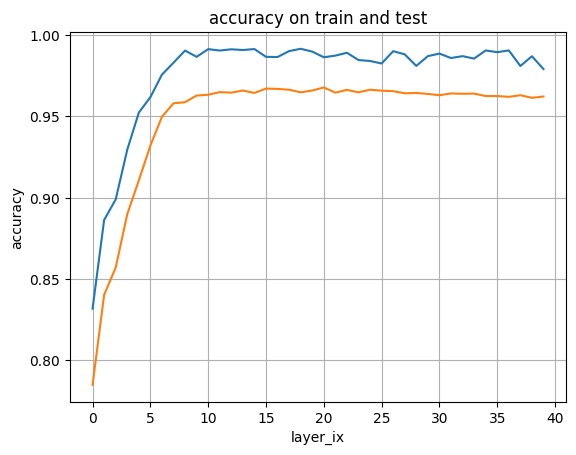

In [116]:
plot_scores(all_scores, "", ("train", "accuracy"))
plot_scores(all_scores, "accuracy on train and test", ("test", "accuracy"))
plt.grid()

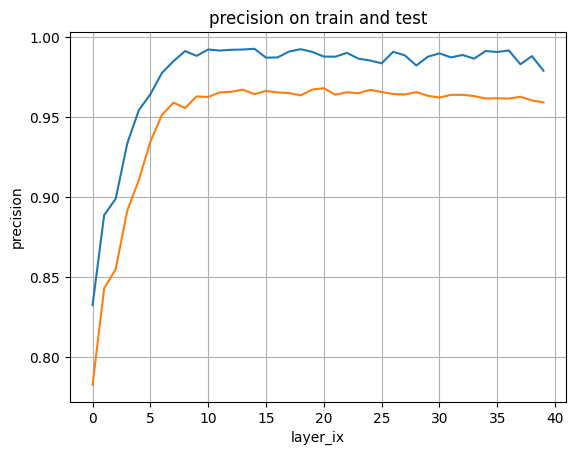

In [117]:
plot_scores(all_scores, "", ("train", "precision"))
plot_scores(all_scores, "precision on train and test", ("test", "precision"))
plt.grid()

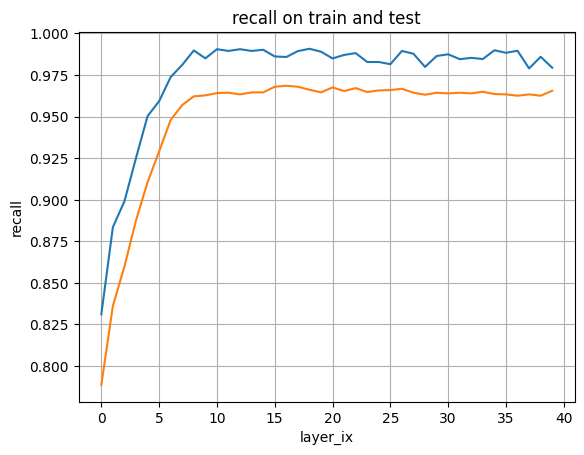

In [118]:
plot_scores(all_scores, "", ("train", "recall"))
plot_scores(all_scores, "recall on train and test", ("test", "recall"))
plt.grid()

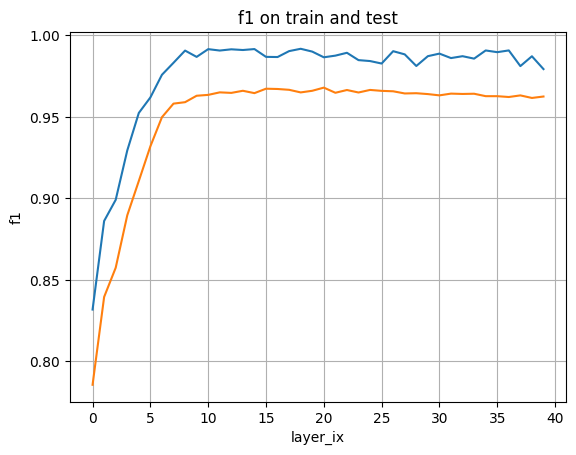

In [119]:
plot_scores(all_scores, "", ("train", "f1"))
plot_scores(all_scores, "f1 on train and test", ("test", "f1"))
plt.grid()